# Zero Shot Learning
In this notebook, we give an example of zero shot learning on bubble dataset. We generate the dataset by normal distribution.
We have the follow position per class:
- top left (seen),
- top right (seen),
- bottom left (seen),
- bottom right (seen),
- middle (unseen).

By the above list the only unseen class of the data is at the middle (position). Next we initialize and train a Feed Forward
(FF) neural network for zero shot task. Finally, we visualize the results by cost/score curve and class space.

In [1]:
import tensorflow as tf

from algomorphism.model.base import BaseNeuralNetwork, LossBase, MetricBase
from algomorphism.model.layers import FullConnected
from algomorphism.dataset.datasets.generate import BubbleDataset
from algomorphism.figure.opt import pca_denoising_figure, multiple_models_history_figure
from algomorphism.method.opt import pca_denoising_preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [2]:
# Optional GPU usage

# for gpu in tf.config.list_physical_devices('GPU'):
#     print(gpu)
#     tf.config.experimental.set_memory_growth(gpu, True)

## Generate Data
Generate Bubble Dataset and plot some examples.

In [3]:
bd = BubbleDataset(n_data=1000, sigma=0.25)

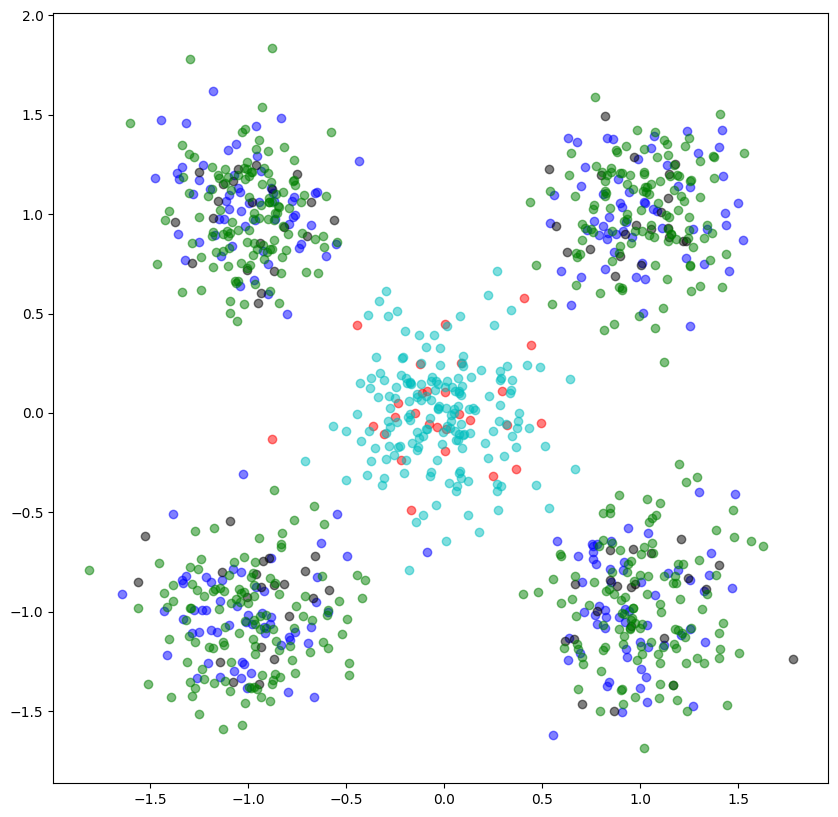

In [4]:
plt.figure(figsize=(10,10))
for x, y, y_hot in bd.val.seen:
    plt.plot(x[:,0], x[:,1], 'ob', alpha=0.5)

for x, y, y_hot in bd.val.unseen:
    plt.plot(x[:,0], x[:,1], 'or', alpha=0.5)

for x, y, y_hot in bd.test.seen:
    plt.plot(x[:,0], x[:,1], 'ok', alpha=0.5)

for x, y, y_hot in bd.test.unseen:
    plt.plot(x[:,0], x[:,1], 'oc', alpha=0.5)

for x, y, y_hot in bd.train:
    plt.plot(x[:,0], x[:,1], 'og', alpha=0.5)

## Initialize 1 Nearest Neighbors Classifier
Train 1 Nearest Neighbors Classifier (1NNC) for post processes of FeedForward output to compute the score.

In [5]:
knn = KNeighborsClassifier(1)
y_one_hot = LabelBinarizer().fit_transform(list(bd.data_dict.keys()))
knn.fit(
    [v['class_emb'] for v in bd.data_dict.values()],
    y_one_hot
)

KNeighborsClassifier(n_neighbors=1)

## Initialize & Train FF Neural Network

In [6]:
class FeedForward(tf.Module, BaseNeuralNetwork):
    def __init__(self, knn, dataset, optimizer=None):
        tf.Module.__init__(self, name='ff')

        status = [
            [0],
            [1],
            [2]
        ]

        self.knn = knn
        self.score_mtr = MetricBase(self,
                                    [tf.keras.metrics.CategoricalAccuracy()],
                                    status,
                                    [0]
                                    )

        self.cost_mtr = MetricBase(self,
                                    [tf.keras.metrics.MeanSquaredError()],
                                    status,
                                    [0],
                                    1
                                    )
        self.cost_loss = LossBase(self,
                                    [tf.keras.losses.MeanSquaredError()],
                                    status,
                                    [0]
                                    )
        BaseNeuralNetwork.__init__(self, status=status, dataset=dataset, optimizer=optimizer)
        self.fc1 = FullConnected(2, 128)
        self.fc2 = FullConnected(128, 256)
        self.fc3 = FullConnected(256, 512)
        self.fc4 = FullConnected(512, 1024)
        self.out = FullConnected(1024, 2)

    def __call__(self, inputs, is_score=False):
        x = self.fc1(inputs[0])
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        y = self.out(x)
        if is_score:
            y = self.knn.predict(y)
        return tuple([y])

In [7]:

opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
ff = FeedForward(knn=knn, dataset=bd, optimizer=opt)

In [8]:
ff.train(bd, 60, print_types=['train', 'val', 'test'])

Epoch 1 finished
train cost: 29.81560516357422
train score: 1.0
val seen cost: 29.987943649291992
val seen score: 0.991525411605835
val unseen cost: 3.68144154548645
val unseen score: 0.0357142873108387
val harmonic: 0.06894519925117493
test seen cost: 28.2209415435791
test seen score: 1.0
test unseen cost: 3.4007184505462646
test unseen score: 0.08139535039663315
test harmonic: 0.1505376249551773
Epoch 2 finished
train cost: 6.4186811447143555
train score: 0.5
val seen cost: 6.287586212158203
val seen score: 0.5
val unseen cost: 0.7529314160346985
val unseen score: 0.4642857015132904
val harmonic: 0.4814814627170563
test seen cost: 5.6365790367126465
test seen score: 0.5
test unseen cost: 0.6594074368476868
test unseen score: 0.447674423456192
test harmonic: 0.47239264845848083
Epoch 3 finished
train cost: 3.5790741443634033
train score: 0.0
val seen cost: 3.544677734375
val seen score: 0.0
val unseen cost: 0.4468715488910675
val unseen score: 0.5714285969734192
val harmonic: 0.0
test

## Results Visualization
1. Plot cost/score curves for train and validation examples,
2. plot 1KNN space with validation and test outputs of FF.

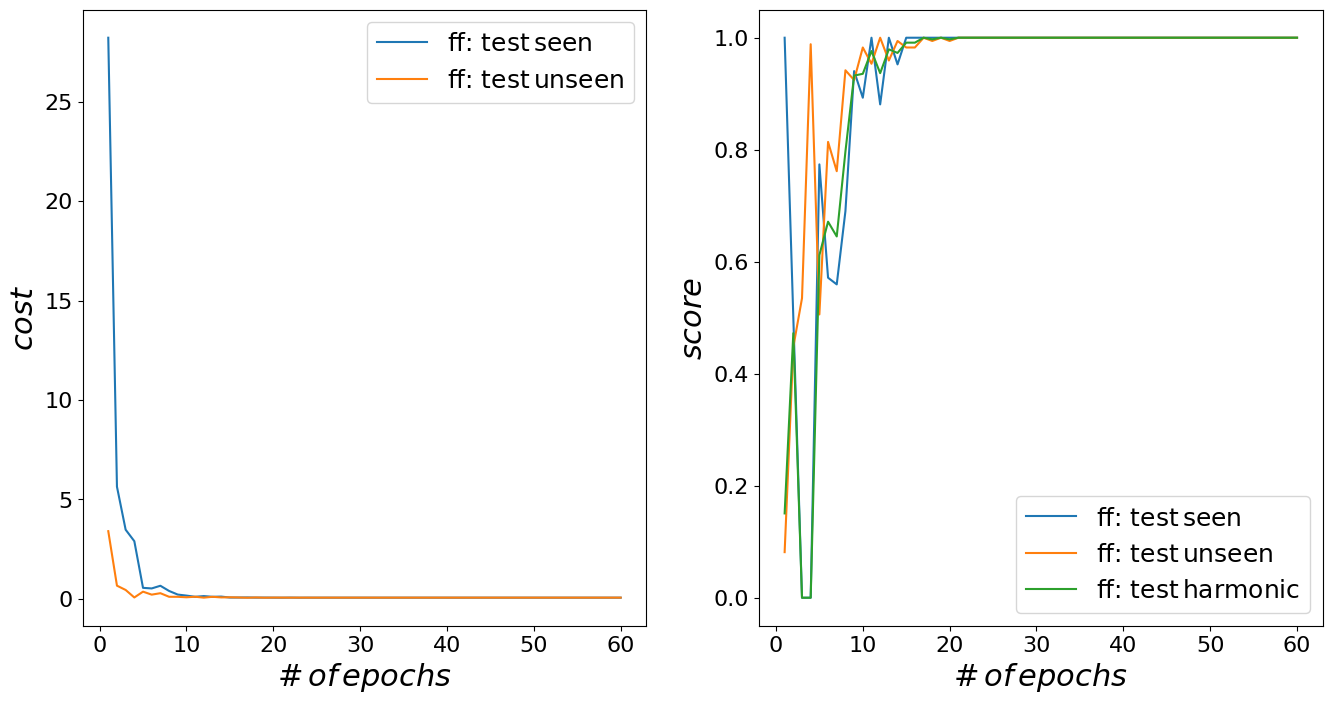

In [9]:
multiple_models_history_figure([ff], ['test'])

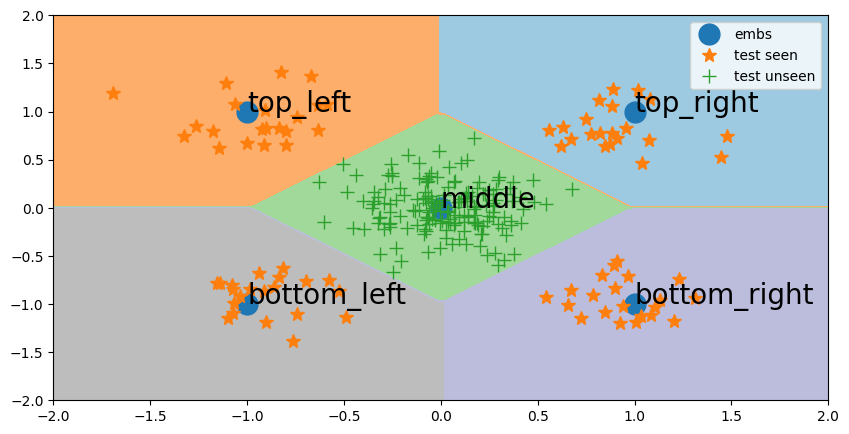

In [10]:
pca_dict, pca_emb, knn_pca = pca_denoising_preprocessing(ff, bd,
                                    [v['class_emb'] for v in bd.data_dict.values()], y_one_hot, pca_emb_idxs=[4, 3, 2, 1, 0],
                                     example_predicted_types=['test_seen', 'test_unseen'])

pca_denoising_figure(pca_dict, pca_emb, knn_pca,
                     list(bd.data_dict.keys()), pca_emb_idxs=[4, 3, 2, 1, 0])
